In [1]:
# A fun side project trying to map stellar spectra to sound
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import h, c, k

In [66]:
# Constants
h = h  # Planck's constant
c = c  # Speed of light
k = k  # Boltzmann constant
wien_constant = 2.897e6  # Wien's displacement constant in nm * Kelvin

In [44]:
# import sound libraries
from pydub import AudioSegment
from pydub.generators import Sine

In [45]:
# Define a quick function for tuning volume of the sound
def vol_frac_to_delta_dB(vol_frac):
    '''
    convert fractional volumn change to change in dB
    make it so that a factor of 2 change is 10 dB
    '''
    return 10*np.log2(vol_frac)

In [46]:
def planck(wavelength, T):
    """
    Function to calculate the blackbody radiation intensity for a given wavelength and temperature.

    There is a way to do this using the astropy library, however, I couldn't
    easily figure it out, so I just created the Planck function from scratch.

    Here's the link to the astropy blackbody model

    Future goal: get this working instead.
    https://docs.astropy.org/en/stable/api/astropy.modeling.physical_models.BlackBody.html
    """
    exponent = h * c / (wavelength * k * T)
    # this approximation was required because I kept getting errors when the
    # exponent was large.
    if exponent > 100:
        intensity = 0.0  # Approximate very large exponent as zero intensity
    else:
        intensity = (2 * h * c**2 / wavelength**5) / (np.exp(exponent) - 1)
    return intensity

def createSpectrum(temperature):
    '''
    Function to create a PDF containing spectrum and other pertinent
    information.
    Calls planck() when needed.
    '''
    # print(student[0],student[1],student[2],student[3])
    # Define the frequency range
    nm = 1.0e-9
    frequencies = np.linspace(c/(4000*nm), c/(25*nm), 2000)  # in Hz
    wavelengths = c / frequencies  # in m

    # Step 4 - call planck(), sending the temperature value
    # and the wavelength range
    intensities = [planck(wavelength, temperature) for wavelength in wavelengths]

    return frequencies, intensities

In [136]:
duration = 1000  # Duration in milliseconds
frequency = 440  # Frequency in Hz (A4)

audio_data1 = Sine(frequency).to_audio_segment(duration=duration)

In [137]:
audio_data1

In [138]:
duration = 1000  # Duration in milliseconds
frequency = 220  # Frequency in Hz (A4)

audio_data2 = Sine(frequency).to_audio_segment(duration=duration)

duration = 1000  # Duration in milliseconds
frequency = 1000  # Frequency in Hz (A4)

audio_data3 = Sine(frequency).to_audio_segment(duration=duration)

In [139]:
audio_data1+audio_data2+audio_data3

In [140]:
audio_data4 = (audio_data1).overlay(audio_data2)
audio_data5 = (audio_data1+vol_frac_to_delta_dB(0.5)).overlay(audio_data2+vol_frac_to_delta_dB(0.5))

In [142]:
print(audio_data1.dBFS, audio_data2.dBFS)
print(audio_data4.dBFS, audio_data5.dBFS)

-3.0108529080336788 -3.0108529080336788
-2.9917543911432576 -10.000965225135376


In [143]:
audio_data4+audio_data5+audio_data1

In [44]:
audio_data1b = audio_data1-10.5
audio_data1c = audio_data1+10.5

In [45]:
audio_data1+audio_data1b+audio_data1c

In [41]:
# check the db of the audio
print(audio_data1.dBFS)
print(audio_data1.max_dBFS)
print(audio_data1.max)

print(audio_data1b.dBFS)
print(audio_data1b.max_dBFS)
print(audio_data1b.max)

-3.0108529080336788
-0.0005301608106181008
32766
-13.511899007156657
-10.500445529489086
9782


In [9]:
# output_file = "test_output.mp3"  # Output filename
# audio_data.export(output_file, format="mp3")

<_io.BufferedRandom name='test_output.mp3'>

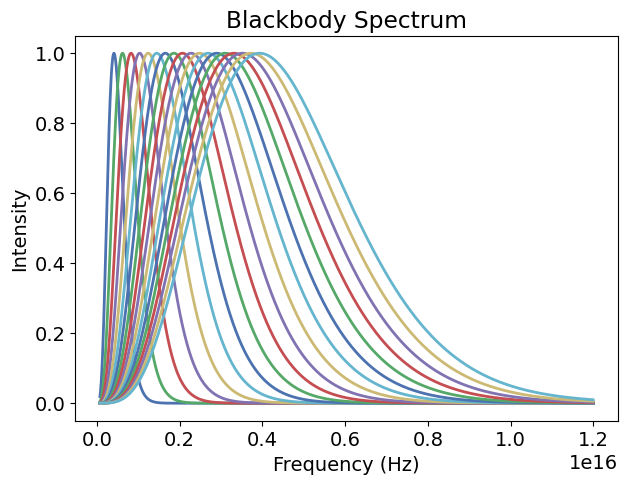

In [75]:
# Plot the blackbody spectra
for T in np.arange(4000,40000,2000):
    fq, it = createSpectrum(T)
    # normalize the intensity by the maximun intensity
    it_norm = it/np.max(it)
    plt.plot(fq, it_norm, label=f'{T}K')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Intensity')
# plt.xscale("log")
plt.title('Blackbody Spectrum')
plt.show()

In [96]:
len(fq)

2000

In [42]:
aud_min = 100
aud_max = 10000
def gen_audio(T,if_log=False):
    fq, it = createSpectrum(T)
    ii = np.arange(len(fq))

    fq_ds, it_ds = fq[::20], it[::20]

    # Normalize the intensity by the maximum intensity
    it_norm = it_ds/np.max(it_ds)
    # Cast the frequency range to human audible sound frequency
    if if_log:
        fq_rc = (np.log10(fq_ds)-np.log10(np.min(fq)))*(aud_max-aud_min)/(np.log10(np.max(fq))-np.log10(np.min(fq))) + aud_min
    else:
        fq_rc = (fq_ds-np.min(fq))*(aud_max-aud_min)/(np.max(fq)-np.min(fq)) + aud_min

    # Overlay the monotracks together
    duration=2000
    audio_data_list = []
    audio_data_list.append(Sine(fq_rc[0]).to_audio_segment(duration=duration))
    int_sum = it_norm[0]

    for ii in range(len(fq_rc[1:])):
    # for ii in range(10):
        # reduce the intensity so that the overlayed version has the same loudness
        int_sum_new = int_sum+it_norm[ii+1]
        it_new = it_norm[ii+1]/int_sum_new
        it_old = int_sum/int_sum_new
        # print(it_new,it_old)
        if it_new > 0.1:
            audio_data1 = audio_data_list[-1]#+vol_frac_to_delta_dB(it_old)
            audio_data2 = Sine(fq_rc[ii+1]).to_audio_segment(duration=duration)+vol_frac_to_delta_dB(it_new)
            audio_data_list.append(audio_data1.overlay(audio_data2))
            # print(audio_data_list[-1].dBFS)
            int_sum = int_sum_new

    return audio_data_list

In [196]:
star_audio_list = []
star_type_list = ["0","B","A","F","G","K","M"]
star_T_list = [40000, 30000, 10000, 7000, 6000, 5000, 4000]

for i in range(len(star_T_list)):
    star_audio_list.append(gen_audio(star_T_list[i],False))

In [197]:
star_audio_list[0][-1]+star_audio_list[1][-1]+star_audio_list[2][-1]+star_audio_list[3][-1]+star_audio_list[4][-1]+star_audio_list[5][-1]+star_audio_list[6][-1]

In [198]:
star_audio_list[0][-1]+star_audio_list[4][-1]+star_audio_list[6][-1]

In [202]:
star_audio_list = []
star_type_list = ["0","B","A","F","G","K","M"]
star_T_list = [40000, 30000, 10000, 7000, 6000, 5000, 4000]

for i in range(len(star_T_list)):
    star_audio_list.append(gen_audio(star_T_list[i],True))

In [203]:
star_audio_list[0][-1]+star_audio_list[1][-1]+star_audio_list[2][-1]+star_audio_list[3][-1]+star_audio_list[4][-1]+star_audio_list[5][-1]+star_audio_list[6][-1]

In [205]:
star_audio_list[0][-1]+star_audio_list[4][-1]+star_audio_list[6][-1]

In [154]:
# Generate a sampling of intensity vs. frequency
T = 40000
fq, it = createSpectrum(T)
ii = np.arange(len(fq))

fq_ds, it_ds = fq[::20], it[::20]

In [178]:
# Normalize the intensity by the maximum intensity
it_norm = it_ds/np.max(it_ds)
# Cast the frequency range to human audible sound frequency via linear transformation
fq_rc = (fq_ds-np.min(fq))*(aud_max-aud_min)/(np.max(fq)-np.min(fq)) + aud_min
# Cast the frequency range to human audible sound frequency via log transformation
fq_rc_log = (np.log10(fq_ds)-np.log10(np.min(fq)))*(aud_max-aud_min)/(np.log10(np.max(fq))-np.log10(np.min(fq))) + aud_min

# frequency_intensity_pairs = [ (fq_i, it_i) for ii_i, fq_i, it_i in zip(ii, fq, it) if ii_i % 100 == 0]        

In [161]:
# Overlay the monotracks together
duration=1000
audio_data_list = []
audio_data_list.append(Sine(fq_rc[0]).to_audio_segment(duration=duration))
int_sum = it_norm[0]

for ii in range(len(fq_rc[1:])):
# for ii in range(10):
    # reduce the intensity so that the overlayed version has the same loudness
    int_sum_new = int_sum+it_norm[ii+1]
    it_new = it_norm[ii+1]/int_sum_new
    it_old = int_sum/int_sum_new
    # print(it_new,it_old)
    if it_new > 0.1:
        audio_data1 = audio_data_list[-1]#+vol_frac_to_delta_dB(it_old)
        audio_data2 = Sine(fq_rc[ii+1]).to_audio_segment(duration=duration)+vol_frac_to_delta_dB(it_new)
        audio_data_list.append(audio_data1.overlay(audio_data2))
        print(audio_data_list[-1].dBFS)
        int_sum = int_sum_new

-2.743221512055774
-3.61429575655769
-4.269310817785577
-4.82630374161512
-5.319161384689063
-5.685215789541008
-5.992019176965272
-6.26359274444855
-6.474390831937232
-6.646450125166368
-6.802242123353955
-6.930803116747142
-7.036231506615898
-7.129091162228171
-7.210785783423889
-7.279762956707732
-7.33632872940737
-7.382716258954903
-7.4237432239545456
-7.463712875793913
-7.498837838430767
-7.525275090871778
-7.547367769279436
-7.5663491790144946
-7.582198768533481
-7.5974416322957605
-7.612711292785156


In [4]:
from galapy.Galaxy import GXY

In [2]:
tau = np.array([
    0.0000000e+00, 2.0674900e+08, 4.2752600e+08, 6.6250900e+08,
    9.1218400e+08, 1.1766550e+09, 1.4557920e+09, 1.7499790e+09,
    2.0585520e+09, 2.3815860e+09, 2.7187860e+09, 3.0688570e+09,
    3.4325970e+09, 3.8068280e+09, 4.1934690e+09, 4.5884250e+09,
    4.9938270e+09, 5.4046790e+09, 5.8241890e+09, 6.2453270e+09,
    6.6728250e+09, 7.0994560e+09, 7.5283510e+09, 7.9562340e+09,
    8.3802740e+09, 8.8046430e+09, 9.2189360e+09, 9.6296370e+09,
    1.0036022e+10, 1.0428195e+10, 1.0814397e+10, 1.1194359e+10,
    1.1555720e+10
])
sfr = np.array([
    0.        , 0.        , 0.00258615, 0.04669582, 0.21555495,
    0.56162186, 0.60869537, 0.55047424, 0.36031803, 0.27614234,
    0.20609573, 0.16298589, 0.2459535 , 0.47935471, 0.57768621,
    0.55990713, 0.52003312, 0.48266521, 0.45552792, 0.43251383,
    0.40347906, 0.36103059, 0.28409527, 0.22353781, 0.17772765,
    0.15988216, 0.1646592 , 0.17408446, 0.19488885, 0.23297054,
    0.2524771 , 0.25091753, 0.23612502
])

In [10]:
len(tau)

33

In [67]:
# redshift of the source
zz = 1.e-4
# current age of the object
age = tau.max()
# average absolute metallicity
Zgxy = 6.74e-3
# dust mass
Mdust = 1.e+9

In [68]:
gxy = GXY(
    age = age, redshift = zz,
    csp = {'ssp_lib':'parsec22.NTL'}, # set the SSP library
    sfh = {
        'model':'interpolated',       # choose the interpolated model
        'tau':tau, 'sfr':sfr,         # pass the dataset simulated with SAM
        'Zgxy':Zgxy, 'Mdust':Mdust    # pass the further properties from the SAM
    },
)

In [69]:
# array of rest-frame wavelengths
wave = gxy.wl()
# array of fluxes in mJy
flux = gxy.get_SED()

In [70]:
components = gxy.components_to_flux()

In [8]:
from galapy.analysis.plot import sed_layout, sed_components, sed_flux

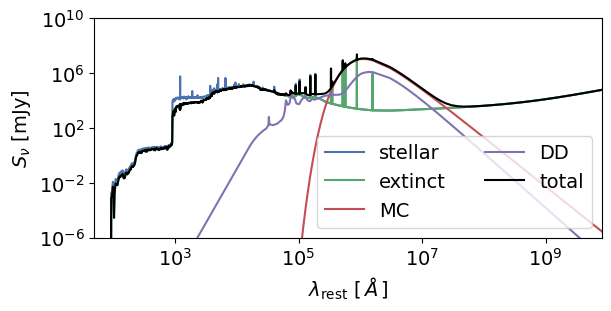

In [60]:
fig, ax = plt.subplots(1,1,figsize=(6,3), constrained_layout=True)

# prepares the plot axes
ax = sed_layout(gxy.redshift, frame='rest', ax = ax, xlim=(50., 8.e+9), ylim=(1.e-6,1.e+10))

# plot the different components
_ = sed_components(
    wave, components,
    redshift=gxy.redshift, frame='rest',
    ax=ax
)

# plot the total flux:
_ = sed_flux(
    wave, flux,
    redshift=gxy.redshift, frame='rest',
    ax=ax
)

# plot a legend
ax.legend(ncols=2)

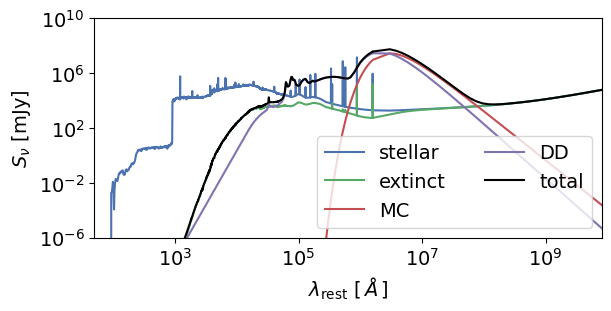

In [71]:
fig, ax = plt.subplots(1,1,figsize=(6,3), constrained_layout=True)

# prepares the plot axes
ax = sed_layout(gxy.redshift, frame='rest', ax = ax, xlim=(50., 8.e+9), ylim=(1.e-6,1.e+10))

# plot the different components
_ = sed_components(
    wave, components,
    redshift=gxy.redshift, frame='rest',
    ax=ax
)

# plot the total flux:
_ = sed_flux(
    wave, flux,
    redshift=gxy.redshift, frame='rest',
    ax=ax
)

# plot a legend
ax.legend(ncols=2)

In [39]:
len(wave),np.min(wave),np.max(wave)

(1562, 1.0, 10000000000.0)

In [40]:
len(flux),np.min(flux),np.max(flux)

(1562, 4.7483409115779984e-32, 54762953.53410807)

In [66]:
wave[mask]

array([9.35000000e+01, 9.61000000e+01, 9.77000000e+01, ...,
       9.48682957e+09, 9.74341478e+09, 1.00000000e+10])

In [72]:
# Convert the wavelength to frequency
frequencies = c / (wave*10**(-10))  # in Hz

# Normalize the intensity by the maximum intensity
flux_norm = np.log10(flux)

# mask out the ones that have intensity less than 1e-6
mask = flux_norm > -6
flux_norm = flux_norm[mask]
frequencies = frequencies[mask]

# Recast the frequency range to human audible sound frequency
fq_rc = (frequencies-np.min(frequencies))*(aud_max-aud_min)/(np.max(frequencies)-np.min(frequencies)) + aud_min

# Overlay the monotracks together
duration=1000
audio_data_list = []
audio_data_list.append(Sine(fq_rc[0]).to_audio_segment(duration=duration))
int_sum = flux_norm[0]

for ii in range(len(fq_rc[1:])):
# for ii in range(10):
    # reduce the intensity so that the overlayed version has the same loudness
    int_sum_new = int_sum+flux_norm[ii+1]
    it_new = flux_norm[ii+1]/int_sum_new
    it_old = int_sum/int_sum_new
    # print(it_new,it_old)
    if it_new > 0.1:
        audio_data1 = audio_data_list[-1]#+vol_frac_to_delta_dB(it_old)
        audio_data2 = Sine(fq_rc[ii+1]).to_audio_segment(duration=duration)+vol_frac_to_delta_dB(it_new)
        audio_data_list.append(audio_data1.overlay(audio_data2))
        print(audio_data_list[-1].dBFS)
        int_sum = int_sum_new

-3.1583056072427764
-3.2730725612538887
-3.3285018150390133
-3.357324973022709
-3.3752903986428864
-3.387027031774549
-3.3952521212174114
-3.4007398444439962


In [73]:
audio_data_list[-1]

In [65]:
audio_data_list[-1]